In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from feature_engine.encoding import RareLabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import catboost
from catboost import Pool, cv

import optuna
from optuna import Trial


from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score, plot_precision_recall_curve

In [2]:
df = pd.read_csv(r'C:\Users\victo\Desktop\kaggle\coupon\in-vehicle-coupon-recommendation.csv')

In [3]:
df= pd.get_dummies(df,columns =['gender','expiration'],drop_first=True )
df.drop(columns = ['direction_opp','car',],inplace=True)

In [4]:
print(df.nunique(axis=0))

destination              3
passanger                4
weather                  3
temperature              3
time                     5
coupon                   5
age                      8
maritalStatus            5
has_children             2
education                6
occupation              25
income                   9
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
toCoupon_GEQ5min         1
toCoupon_GEQ15min        2
toCoupon_GEQ25min        2
direction_same           2
Y                        2
gender_Male              2
expiration_2h            2
dtype: int64


In [5]:
df.drop(columns = ['toCoupon_GEQ5min'],inplace=True)

In [6]:
def ordinal_encode(data):
    df = data.copy()
    df["age"].replace({'below21': 0, "21": 1, "26":2, "31": 3, "36":4, "41":5,"46":6,"50plus":7}, inplace=True)
    
    df['time'].replace({'2PM': 14, '10AM': 10, "6PM": 18, "7AM": 7, "10PM": 22} , inplace=True)
    
    df['income'].replace({'Less than $12500':0, '$12500 - $24999':1 ,'$25000 - $37499':2,
           '$37500 - $49999':3, '$50000 - $62499':4, '$62500 - $74999':5,
           '$75000 - $87499':6, '$87500 - $99999':7,'$100000 or More':8},inplace=True)
    
    df['education'].replace({'Some High School':0, 'High School Graduate':1 ,'Some college - no degree':2,
           'Associates degree':3, 'Bachelors degree':4, 'Graduate degree (Masters or Doctorate)':5,
                                                                           },inplace=True)
    df['temperature'].replace({30:0, 55:1,80:2},inplace=True)
    return df
df= ordinal_encode(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Y']), df.Y.values, test_size=0.30, random_state=714)


In [8]:
def find_freq_cats(df, variable, tolerance):
    temp = df.groupby([variable])[variable].count() / len(df)
    freq = [x for x in temp.loc[temp> tolerance].index.values]
    return freq
labels = find_freq_cats(X_test,'occupation',.06)
labels

['Computer & Mathematical',
 'Education&Training&Library',
 'Management',
 'Sales & Related',
 'Student',
 'Unemployed']

In [9]:
rare_encoder = RareLabelEncoder(tol=.06, variables= ['occupation'])
rare_encoder.fit(X_train)
X_train = rare_encoder.fit_transform(X_train)
X_test = rare_encoder.fit_transform(X_test)

In [10]:
print((X_train.occupation.unique())),((X_test.occupation.unique()))

['Computer & Mathematical' 'Rare' 'Unemployed' 'Student'
 'Education&Training&Library' 'Sales & Related' 'Management']


(None,
 array(['Sales & Related', 'Computer & Mathematical', 'Rare',
        'Education&Training&Library', 'Unemployed', 'Student',
        'Management'], dtype=object))

In [11]:
ohe_cats = ['destination','passanger','weather','coupon','maritalStatus','Bar','CoffeeHouse','CarryAway',
            'RestaurantLessThan20','Restaurant20To50','occupation']

In [12]:
cat_transform = Pipeline(steps = [
                                ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan)),
                                 ('oh_enc', OneHotEncoder(sparse=False))
                                    ])
preprocessor = ColumnTransformer([(
                                    'cats', cat_transform, ohe_cats,)
                                ],remainder="passthrough")

In [13]:
preprocessor.fit(X_train)
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)

In [14]:
(len(X_train_pro))

8878

## Feature Selection

In [19]:
'''rf_clf = RandomForestClassifier() 
rfecv = RFECV(estimator=rf_clf, step=1, cv=5,scoring='roc_auc')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_pro, y_train)'''

In [24]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', pd.DataFrame(X_train_pro).columns[rfecv.support_])
best_features = np.array(pd.DataFrame(X_train_pro).columns[rfecv.support_])

Optimal number of features : 50
Best features : Int64Index([ 0,  1,  2,  3,  4,  9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 23,
            24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 43, 44, 45,
            46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63],
           dtype='int64')


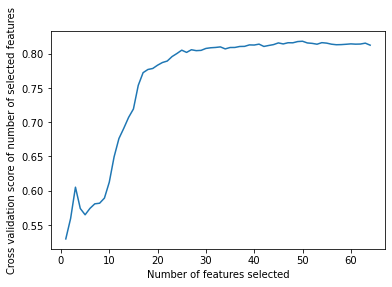

In [29]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
#Overall did not help with model selection after testing

## Model Selection

In [18]:
#split train test set processed
preprocessor.fit(X_train)
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)

In [19]:
len(X_test_pro)

3806

In [23]:
#splits training set to training and validation set 
X_train_pro_, X_test_, y_train_, y_test_ = train_test_split(X_train_pro, y_train, test_size=0.30, random_state=714)


In [85]:
SI = Pipeline(steps = [
                                ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan))])
SI.fit(X_train)
X_na = SI.transform(X_train)
X_test_cat = SI.transform(X_test)

X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X_na, y_train, test_size=0.30, random_state=714)


In [27]:
rf_parms = { 'criterion': 'entropy', 'n_estimators': 3305, 'max_depth': 20, 'max_features': 'sqrt'}
rf_clfer  = RandomForestClassifier(**rf_parms)


xgb_params = {'objective':'binary:logistic','booster': 'gbtree', 'lambda': 3.995352168000524e-05, 'alpha': 1.7796504089335072e-06,
              'subsample': 0.8432765832522267, 'colsample_bytree': 0.6145568641240514, 'learning_rate': 0.021418254141152098, 
              'max_depth': 7, 'gamma': 1.3213282383643845, 'min_child_weight': 0.41928725218821056, 'n_estimators':5000
             }
xgb_clfer =  xgb.XGBClassifier(**xgb_params)



cat_params = {'objective': 'Logloss', 'colsample_bylevel': 0.09924752074817642, 'depth': 7, 
              'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4969870635599054,"n_estimators" : 2000
             #'eval_metric' :'AUC'
             }
cat_clfer =catboost.CatBoostClassifier(**cat_params)

cat_features = np.arange(0,21)
lgb_params={'objective': 'binary', 'metric': 'binary_logloss', 
           'verbosity': -1, 'boosting_type': 'gbdt', 'device_type': 'gpu', 
           'feature_pre_filter': False,'lambda_l1': 1.1510937191844763e-08,
           'lambda_l2': 2.7256100916312845e-08, 'num_leaves': 31, 
           'feature_fraction': 0.7, 'bagging_fraction': 0.9298048538046241,
           'bagging_freq': 3, 'min_child_samples': 20, 'n_estimators':5000}

gbm_clfer = lgb.LGBMClassifier(**lgb_params)

nb_clfer = GaussianNB()

In [26]:
nb_clfer.fit(X_train_pro_, y_train_)

GaussianNB()

In [28]:
xgb_clfer.fit(X_train_pro_, y_train_,eval_set=[(X_test_, y_test_)],early_stopping_rounds=50,eval_metric=['auc'])
rf_clfer.fit(X_train_pro,y_train)
gbm_clfer.fit(X_train_pro_, y_train_,eval_set=[(X_test_, y_test_)],early_stopping_rounds=50,eval_metric=['auc'])
cat_clfer.fit(X_train_na,y_train_na,cat_features= cat_features,eval_set=[(X_test_na,y_test_na)],
              early_stopping_rounds=50,plot=False)
nb_clfer.fit(X_train_pro_, y_train_)

[0]	validation_0-auc:0.72412
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.73141
[2]	validation_0-auc:0.74979
[3]	validation_0-auc:0.76405
[4]	validation_0-auc:0.77159
[5]	validation_0-auc:0.77624
[6]	validation_0-auc:0.77958
[7]	validation_0-auc:0.78164
[8]	validation_0-auc:0.78196
[9]	validation_0-auc:0.78314
[10]	validation_0-auc:0.78509
[11]	validation_0-auc:0.78644
[12]	validation_0-auc:0.78729
[13]	validation_0-auc:0.78693
[14]	validation_0-auc:0.78736
[15]	validation_0-auc:0.78717
[16]	validation_0-auc:0.78831
[17]	validation_0-auc:0.78825
[18]	validation_0-auc:0.78946
[19]	validation_0-auc:0.78940
[20]	validation_0-auc:0.78901
[21]	validation_0-auc:0.78842
[22]	validation_0-auc:0.78870
[23]	validation_0-auc:0.78914
[24]	validation_0-auc:0.78983
[25]	validation_0-auc:0.78994
[26]	validation_0-auc:0.78995
[27]	validation_0-auc:0.78979
[28]	validation_0-auc:0.79019
[29]	validation_0-auc:0.78969
[30]	validation_0-auc:0.78992
[31]	validation_

GaussianNB()

In [30]:
cat_best_iter = cat_clfer.get_best_iteration()


In [37]:
rf_preds=rf_clfer.predict_proba(X_test_)[:, 1]
xgb_preds=xgb_clfer.predict_proba(X_test_,ntree_limit=xgb_clfer.best_ntree_limit)[:, 1]
gbm_preds=gbm_clfer.predict_proba(X_test_)[:, 1]
cat_preds=cat_clfer.predict_proba(X_test_na,ntree_end=cat_best_iter)[:, 1]
nb_preds = nb_clfer.predict_proba(X_test_)[:, 1]

In [38]:
print('Random Forest AUC SCORE: ', roc_auc_score(y_test_, rf_preds))
print('XGB AUC SCORE: ', roc_auc_score(y_test_, rf_preds))
print('GBM AUC SCORE: ', roc_auc_score(y_test_, rf_preds))
print('CAT AUC SCORE: ', roc_auc_score(y_test_, cat_preds))
print('NB AUC SCORE: ', roc_auc_score(y_test_, nb_preds))


Random Forest AUC SCORE:  0.999998852947266
XGB AUC SCORE:  0.999998852947266
GBM AUC SCORE:  0.999998852947266
CAT AUC SCORE:  0.823103247937169
NB AUC SCORE:  0.6904787167232832


## Test Set

In [92]:
rf_test_pred=rf_clfer.predict_proba(X_test_pro)[:, 1]
xgb_test_pred=xgb_clfer.predict_proba(X_test_pro,ntree_limit=xgb_clfer.best_ntree_limit)[:, 1]
gbm_test_pred=gbm_clfer.predict_proba(X_test_pro)[:, 1]
cat_test_pred=cat_clfer.predict_proba(X_test_cat,ntree_end=cat_best_iter)[:, 1]
nb_test_pred = nb_clfer.predict_proba(X_test_pro)[:, 1]

In [93]:
def show_metrics(y_pred,y_test,clf_name):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    sns.heatmap((confusion_matrix(y_pred,y_test)),annot= True,cmap='Blues',fmt='g',cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel('True')
    plt.title(f'{clf_name}')
    plt.show()
    print(f'{classification_report(y_pred,y_test)}')

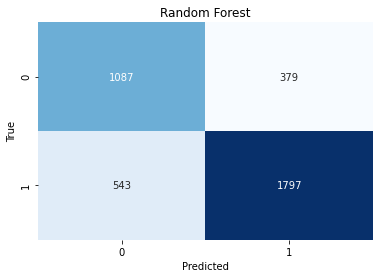

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1466
           1       0.83      0.77      0.80      2340

    accuracy                           0.76      3806
   macro avg       0.75      0.75      0.75      3806
weighted avg       0.76      0.76      0.76      3806



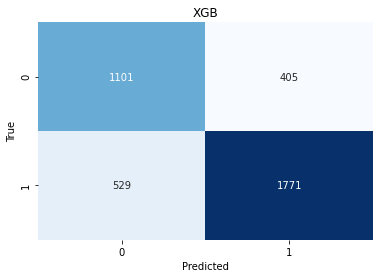

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1506
           1       0.81      0.77      0.79      2300

    accuracy                           0.75      3806
   macro avg       0.74      0.75      0.75      3806
weighted avg       0.76      0.75      0.76      3806



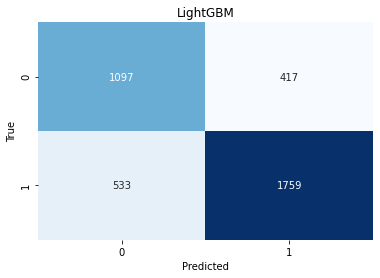

              precision    recall  f1-score   support

           0       0.67      0.72      0.70      1514
           1       0.81      0.77      0.79      2292

    accuracy                           0.75      3806
   macro avg       0.74      0.75      0.74      3806
weighted avg       0.75      0.75      0.75      3806



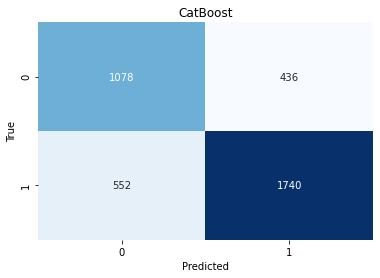

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1514
           1       0.80      0.76      0.78      2292

    accuracy                           0.74      3806
   macro avg       0.73      0.74      0.73      3806
weighted avg       0.74      0.74      0.74      3806



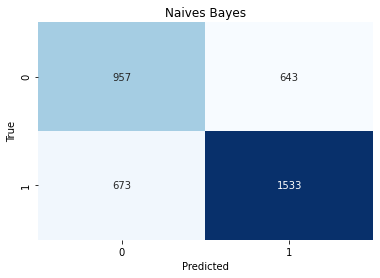

              precision    recall  f1-score   support

           0       0.59      0.60      0.59      1600
           1       0.70      0.69      0.70      2206

    accuracy                           0.65      3806
   macro avg       0.65      0.65      0.65      3806
weighted avg       0.66      0.65      0.65      3806



In [94]:
show_metrics(rf_clfer.predict(X_test_pro),y_test,'Random Forest')
show_metrics(xgb_clfer.predict(X_test_pro),y_test, 'XGB')
show_metrics(gbm_clfer.predict(X_test_pro),y_test,'LightGBM')
show_metrics(cat_clfer.predict(X_test_cat),y_test, 'CatBoost')
show_metrics(nb_clfer.predict(X_test_pro),y_test, 'Naives Bayes')


In [95]:
rf_auc = roc_auc_score(y_test, rf_test_pred)
xgb_auc = roc_auc_score(y_test, xgb_test_pred)
gbm_auc = roc_auc_score(y_test,  gbm_test_pred)
cat_auc = roc_auc_score(y_test,  cat_test_pred)
nb_auc = roc_auc_score(y_test,  nb_test_pred)

roc =[]
roc.append(rf_auc)
roc.append(xgb_auc)
roc.append(gbm_auc)
roc.append(cat_auc)
roc.append(nb_auc)


In [97]:
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test,rf_test_pred )
x_fpr, x_tpr, x_threshold = roc_curve(y_test, xgb_test_pred)
lgb_fpr, lgb_tpr, lgb_threshold = roc_curve(y_test, gbm_test_pred)
cat_fpr, cat_tpr, cat_threshold = roc_curve(y_test, cat_test_pred)
nb_fpr, nb_tpr, nb_threshold = roc_curve(y_test, nb_test_pred)

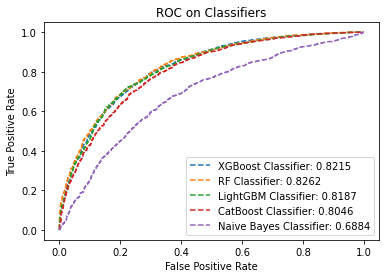

In [98]:
plt.title('ROC on Classifiers')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_fpr,x_tpr,linestyle='--', label = 'XGBoost Classifier: {:.4f}'.format( xgb_auc))
plt.plot(rf_fpr,rf_tpr, linestyle='--',label = 'RF Classifier: {:.4f}'.format(rf_auc))
plt.plot(lgb_fpr,lgb_tpr, linestyle='--',label = 'LightGBM Classifier: {:.4f}'.format(gbm_auc))
plt.plot(cat_fpr,cat_tpr, linestyle='--',label = 'CatBoost Classifier: {:.4f}'.format(cat_auc))
plt.plot(nb_fpr,nb_tpr, linestyle='--',label = 'Naive Bayes Classifier: {:.4f}'.format(nb_auc))

plt.legend()

In [99]:
def df_scores(y_pred,y_test):
    precision = []
    recall = []
    f1 = []
    index = []
    f1_ = f1_score(y_pred,y_test)    
    precision_ = precision_score(y_pred,y_test)
    recall_ = recall_score(y_pred,y_test)
    accuracy_score_ = accuracy_score(y_pred,y_test)
    
    '''    df['F1'] = f1
    df['Precision'] = precision
    df['Recall'] = recall
    df['Models'] = index
    df['Accuracy'] = recall'''
    return f1_, precision_, recall_, accuracy_score_

In [104]:
rf_scores= df_scores(rf_clfer.predict(X_test_pro),y_test)
xgb_scores= df_scores(xgb_clfer.predict(X_test_pro),y_test)
gb_scores= df_scores(gbm_clfer.predict(X_test_pro),y_test)
cat_scores= df_scores(cat_clfer.predict(X_test_cat),y_test)
nb_scores= df_scores(nb_clfer.predict(X_test_pro),y_test)

In [106]:
scores = pd.DataFrame({
    "Random_Forest":rf_scores,
    "XGB": xgb_scores,
    "LightGBM": gb_scores,
    "CatBoost": cat_scores,
    "Naive bayes":nb_scores        }).T
scores= scores.rename(columns={0:'F1', 1:'Precision', 2:'Recall', 3: 'Accuracy'})
scores['AUC'] = roc

In [107]:
print(scores.sort_values(by=['AUC','F1'],ascending=False))

                     F1  Precision    Recall  Accuracy       AUC
Random_Forest  0.795837   0.825827  0.767949  0.757751  0.826179
XGB            0.791332   0.813879  0.770000  0.754598  0.821520
LightGBM       0.787377   0.808364  0.767452  0.750394  0.818712
CatBoost       0.778872   0.799632  0.759162  0.740410  0.804576
Naive bayes    0.699681   0.704504  0.694923  0.654230  0.688435


## Random Forest

In [31]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    n_estimators = trial.suggest_int('n_estimators', 100, 5000)
    max_depth = trial.suggest_int('max_depth', 5, 35)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    model = RandomForestClassifier(n_estimators =n_estimators, max_depth = max_depth, max_features=max_features,criterion =criterion)
    
    score = cross_val_score(model, X_train_pro, y_train, n_jobs=-1, cv=3,scoring= 'roc_auc')
    acc = score.mean()
    return acc

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=600)

[I 2021-10-04 08:42:47,069] A new study created in memory with name: no-name-b0ad2158-2506-4af9-b37d-880b23f6ec76
[I 2021-10-04 08:42:59,386] Trial 0 finished with value: 0.7880762402094553 and parameters: {'criterion': 'gini', 'n_estimators': 3032, 'max_depth': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7880762402094553.
[I 2021-10-04 08:43:10,168] Trial 1 finished with value: 0.8154542637208535 and parameters: {'criterion': 'entropy', 'n_estimators': 1439, 'max_depth': 28, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8154542637208535.
[I 2021-10-04 08:43:14,548] Trial 2 finished with value: 0.7943649265874165 and parameters: {'criterion': 'entropy', 'n_estimators': 880, 'max_depth': 10, 'max_features': 'auto'}. Best is trial 1 with value: 0.8154542637208535.
[I 2021-10-04 08:43:18,687] Trial 3 finished with value: 0.7800533049105867 and parameters: {'criterion': 'gini', 'n_estimators': 988, 'max_depth': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 

In [25]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 37
Best trial:
  Value: 0.8157916702047502
  Params: 
    criterion: entropy
    n_estimators: 3305
    max_depth: 20
    max_features: auto


## XGB

In [89]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train_pro, label=y_train)
    param = {
        'tree_method' : "gpu_hist",
        'single_precision_histogram' :True,
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        # use exact for small dataset.
        "tree_method": "exact",
        # Dart booster is utilzing dropouts
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "learning_rate" :trial.suggest_loguniform('learning_rate', .005, .05),
        #"n_estimators" : trial.suggest_int('n_estimators', 100, 1500),
        "max_depth" : trial.suggest_int('max_depth', 2, 20),
        "gamma" : trial.suggest_loguniform("gamma", 1e-8, 5.0),
        "min_child_weight" :  trial.suggest_loguniform("min_child_weight", .1, 10.),
    }
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(param, dtrain, num_boost_round=2000,
                     early_stopping_rounds=50,shuffle=True,seed=1, callbacks=[pruning_callback])
    mean_auc = history["test-logloss-mean"].values[-1]
    return mean_auc

In [ ]:
study3 = optuna.create_study(direction="minimize")
study3.optimize(objective, timeout = 3600)

[I 2021-10-15 13:35:32,925] A new study created in memory with name: no-name-f276b33a-a1c3-4cd3-bb54-33d5222a67c5
[I 2021-10-15 13:57:22,163] Trial 0 finished with value: 0.5210753333333332 and parameters: {'booster': 'dart', 'lambda': 1.66172335915631e-05, 'alpha': 0.11714265024181786, 'subsample': 0.5830156502238983, 'colsample_bytree': 0.772992122635445, 'learning_rate': 0.010056019223129717, 'max_depth': 5, 'gamma': 0.0009737616978633545, 'min_child_weight': 9.946103035200492, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.980808072126623e-05, 'skip_drop': 8.577379581466447e-08}. Best is trial 0 with value: 0.5210753333333332.
[I 2021-10-15 13:57:28,796] Trial 1 finished with value: 0.5284939999999999 and parameters: {'booster': 'gbtree', 'lambda': 1.662353660081805e-05, 'alpha': 2.5334679120666368e-05, 'subsample': 0.9006108385118303, 'colsample_bytree': 0.8660974972582443, 'learning_rate': 0.018226227347793156, 'max_depth': 19, 'gamma': 0.0001342832381657939

In [88]:
xgb_params = {'booster': 'gbtree', 'lambda': 0.00010523703876762463,
              'alpha': 0.0006833753685742218, 'subsample': 0.9349575408814379, 
              'colsample_bytree': 0.34880508674737537, 'learning_rate': 0.009936163323757031,
              'max_depth': 10, 'gamma': 1.410694107976458e-08, 'min_child_weight': 2.987568242939395}

In [ ]:
{'booster': 'dart', 'lambda': 7.575634203369217e-06, 'alpha': 0.001852376539438152,
 'subsample': 0.7809563713602394, 'colsample_bytree': 0.43804511392238177, 'learning_rate': 0.012631027610068696, 
 'max_depth': 8, 'gamma': 5.0444624963719695e-08, 'min_child_weight': 0.3912153668425309, 'sample_type': 'weighted',
 'normalize_type': 'forest', 
 'rate_drop': 1.0565633996719451e-07, 'skip_drop': 0.0013099461918864852}

In [ ]:
print(study3.best_params)    
print(study3.best_value)
print(study3.best_trial)

In [83]:
trial = study.best_trial

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study3.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## CatBoost

In [18]:
SI = Pipeline(steps = [
                                ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan))])
SI.fit(X_train)
X_na = SI.transform(X_train)

In [19]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_na, y_train, test_size=0.3)
    param = {
        'n_estimators' : 3000,
        'eval_metric': 'AUC',
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        
    cat_features = np.arange(0,21)
    gbm = catboost.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y,cat_features=cat_features, eval_set=[(valid_x, valid_y)], verbose=0,
            early_stopping_rounds=100,
           # eval_metrics='AUC'
           )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(valid_y, pred_labels)
    return auc


In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100,timeout=3600)

[I 2021-10-01 08:26:00,780] A new study created in memory with name: no-name-6ef9efb4-3ad2-448f-958a-cd65075b49fe
[I 2021-10-01 08:31:51,901] Trial 0 finished with value: 0.73620320486255 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08574387263369831, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.73620320486255.
[I 2021-10-01 08:32:14,612] Trial 1 finished with value: 0.739855820096002 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04646447474577557, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16944516960389155}. Best is trial 1 with value: 0.739855820096002.
[I 2021-10-01 08:32:41,283] Trial 2 finished with value: 0.7233003656914894 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09826023742248528, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.739855820096002.
[I 2021-10-01 08:32:42,236] Trial 3 

In [21]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 58
Best trial:
  Value: 0.7514350553617162
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09924752074817642
    depth: 7
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.4969870635599054


## Light

In [37]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import KFold

In [38]:
dtrain = lgb.Dataset(X_train_pro, label=y_train)

In [ ]:
import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(X_train_pro, label=y_train)
best_params, tuning_history = dict(), list()
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "device_type": "gpu",
       
    }

tuner = lgb.LightGBMTunerCV(
        params, dtrain, verbose_eval=100, early_stopping_rounds=25, folds=KFold(n_splits=4),time_budget=19800
        )
    

tuner.run()

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [60]:
params ={'objective': 'binary', 'metric': 'binary_logloss', 
           'verbosity': -1, 'boosting_type': 'gbdt', 'device_type': 'gpu', 
           'feature_pre_filter': False,'lambda_l1': 1.1510937191844763e-08,
           'lambda_l2': 2.7256100916312845e-08, 'num_leaves': 31, 
           'feature_fraction': 0.7, 'bagging_fraction': 0.9298048538046241,
           'bagging_freq': 3, 'min_child_samples': 20, 'n_estimators':5000}

In [69]:
roc_auc_score(y_test,  gbm_clfer.predict_proba(X_test_pro)[:, 1])

0.8318536291050163

In [ ]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = RepeatedKFold(n_splits=5, shuffle=True, random_state=1)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)
study = optuna.create_study(direction="maximize",study_name ='LightGBM')
study.optimize(objective, n_trials= 1)